In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from fedbiomed.common.training_plans import TorchTrainingPlan
from fedbiomed.common.data import DataManager
import pandas as pd
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import logging
logger = logging.getLogger(__name__)
# Dataset personalizado que carga CSV desde la ruta local del nodo
class BreastCancerDataset(Dataset):
    def __init__(self, csv_path):
        df = pd.read_csv(csv_path)
        # Asumiendo que las columnas de características están en df.columns[:-1]
        # y la última columna es la etiqueta
        X = df.iloc[:, :-1].values.astype(np.float32)
        y = df.iloc[:, -1].values.astype(np.int64)

        # Normalizar características
        scaler = StandardScaler()
        X = scaler.fit_transform(X)

        self.X = torch.tensor(X)
        self.y = torch.tensor(y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

from fedbiomed.common.training_plans import TorchTrainingPlan
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd
import numpy as np

class MyTrainingPlan(TorchTrainingPlan):

    class BreastCancerDataset(torch.utils.data.Dataset):
        def __init__(self, csv_path):
            df = pd.read_csv(csv_path)
            X = df.iloc[:, :-1].values.astype(np.float32)
            y = df.iloc[:, -1].values.astype(np.int64)
            scaler = StandardScaler()
            X = scaler.fit_transform(X)
            self.X = torch.tensor(X)
            self.y = torch.tensor(y)

        def __len__(self):
            return len(self.y)

        def __getitem__(self, idx):
            return self.X[idx], self.y[idx]

    def init_model(self, model_args):
        class Net(nn.Module):
            def __init__(self):
                super().__init__()
                self.fc1 = nn.Linear(512, 16)
                self.fc2 = nn.Linear(16, 2)

            def forward(self, x):
                x = F.relu(self.fc1(x))
                x = self.fc2(x)
                return F.log_softmax(x, dim=1)
        return Net()

    def init_optim(self):
        try:
            import torch.nn as nn
            import torch
    
            weights = torch.tensor([0.616, 2.660], dtype=torch.float32)
            logger.info(">>> usando CrossEntropyLoss con pesos = %s", weights)
    
            criterion = nn.CrossEntropyLoss(weight=weights)
            optimizer = torch.optim.Adam(self.model().parameters(), lr=self.optimizer_args['lr'])
            return optimizer, criterion
    
        except Exception as e:
            print(">>> ERROR en init_optim:", str(e))
            raise


    def init_dependencies(self):
        return [
            "import numpy as np",
            "import pandas as pd",
            "from sklearn.preprocessing import StandardScaler",
            "import torch",
            "import torch.nn.functional as F",
            "from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score",
            "from sklearn.model_selection import train_test_split",  # <--- esta línea es la clave
            "from torch.utils.data import TensorDataset"
        ]

    
    def training_data(self):
        df = pd.read_csv(self.dataset_path)
        X = df.iloc[:, :-1].values.astype(np.float32)
        y = df.iloc[:, -1].values.astype(np.int64)
        X = StandardScaler().fit_transform(X)
    
        # Split manual (como Fed-BioMed lo haría)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
        # Guarda el conjunto de test para luego evaluarlo manualmente si deseas
        self.X_val = torch.tensor(X_test)
        self.y_val = torch.tensor(y_test)
    
        dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
        return DataManager(dataset=dataset, batch_size=32, shuffle=True)
        
    def training_step(self, data, target, epoch=None):
        # Entrenamiento normal
        self.model().train()
        output = self.model().forward(data)
        loss = F.nll_loss(output, target)
        return loss
        
   
    def evaluate(self, data, target):
        """
        Fed-BioMed invoca esto sobre cada batch de validación
        (cuando tengas test_on_global_updates=True).
        Debe devolver un dict {<metric_name>: value, …}.
        """
        logger.info(">>> Ejecutando método evaluate personalizado")
        #raise RuntimeError("Este evaluate() sí se está ejecutando.")
        self.model().eval()
        with torch.no_grad():
            logits = self.model()(data)
            loss   = F.nll_loss(logits, target).item()
            preds  = logits.argmax(dim=1).cpu().numpy()
            y_true = target.cpu().numpy()

            # calcula todas tus métricas
            acc  = (preds == y_true).mean()
            prec = precision_score(y_true, preds, average='weighted', zero_division=0)
            rec  = recall_score(y_true, preds, average='weighted', zero_division=0)
            f1   = f1_score(y_true, preds, average='weighted', zero_division=0)

            metrics = {
                        'global/loss':      loss,
                        'global/accuracy':  acc,
                        'global/precision': prec,
                        'global/recall':    rec,
                        'global/f1_score':  f1
            }
    
            # loguea las métricas para TensorBoard
            for name, val in metrics.items():
                self.log(name, val)

            logger.info(f"Evaluating metrics: acc={acc}, prec={prec}, recall={rec}, f1={f1}")

    
        return metrics


In [2]:
from fedbiomed.researcher.federated_workflows import Experiment
from fedbiomed.researcher.aggregators.fedavg import FedAverage
from fedbiomed.common.metrics import MetricTypes

tags = ['mama', 'cancer','mamografia']  # los tags con los que etiquetaste tu dataset en los nodos
rounds = 5
model_args = {}

# ——— Cambia aquí: añade test_ratio, test_on_global_updates y test_metric ———
training_args = {
    'loader_args':            {'batch_size': 32},
    'optimizer_args':         {'lr': 1e-3},
    'epochs':                 10,
    'dry_run':                False,
    'batch_maxnum':           100,

    # split local train/val y evalúa globalmente
    'test_ratio':             0.2,  
    'test_on_global_updates': True,
    'test_metric': MetricTypes.ACCURACY,
    'test_on_global_updates': True,
    'test_on_local_updates': True,
    'log_interval':           10
}

exp = Experiment(
    tags=tags,
    model_args=model_args,
    training_plan_class=MyTrainingPlan,
    training_args=training_args,
    round_limit=rounds,
    aggregator=FedAverage(),
    tensorboard=True
)

# Ejecuta el entrenamiento y guarda el resultado
results = exp.run()

# Guardas los pesos aprendidos en un .pth
exp.training_plan().export_model('modelo_federado.pth')

2025-10-03 03:04:26,121 fedbiomed INFO - Starting researcher service...

2025-10-03 03:04:26,131 fedbiomed INFO - Waiting 3s for nodes to connect...

2025-10-03 03:04:26,321 fedbiomed DEBUG - Node: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d polling for the tasks

2025-10-03 03:04:26,329 fedbiomed DEBUG - Node: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 polling for the tasks

2025-10-03 03:04:29,136 fedbiomed INFO - Updating training data. This action will update FederatedDataset, and the nodes that will participate to the experiment.

2025-10-03 03:04:29,198 fedbiomed DEBUG - Node: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 polling for the tasks

2025-10-03 03:04:29,230 fedbiomed DEBUG - Node: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d polling for the tasks

2025-10-03 03:04:29,235 fedbiomed INFO - Node selected for training -> NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d

2025-10-03 03:04:29,236 fedbiomed INFO - Node selected for training -> NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579

<function extract_symbols at 0x7f19a038bac0>


2025-10-03 03:04:29,353 fedbiomed DEBUG - Model file has been saved: /home/gersa/fedbiomed-dcm/Modulo_DICOM/fbm-researcher/var/experiments/Experiment_0192/model_c8002e16-89b7-4d03-8e84-0b1098e2d98f.py

Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.


2025-10-03 03:04:29,357 fedbiomed INFO - Removing tensorboard logs from previous experiment

2025-10-03 03:04:29,359 fedbiomed INFO - Sampled nodes in round 0 ['NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d', 'NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579']

<function extract_symbols at 0x7f19a038bac0>


2025-10-03 03:04:29,362 fedbiomed INFO - Sending request 
					 To: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Request: : TRAIN
 -----------------------------------------------------------------

2025-10-03 03:04:29,364 fedbiomed INFO - Sending request 
					 To: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Request: : TRAIN
 -----------------------------------------------------------------

2025-10-03 03:04:29,375 fedbiomed DEBUG - Node: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 polling for the tasks

2025-10-03 03:04:29,377 fedbiomed DEBUG - Node: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d polling for the tasks

2025-10-03 03:04:29,685 fedbiomed INFO - VALIDATION ON GLOBAL UPDATES 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 | Iteration: 1/1 (100%) | Samples: 635/635
 					 ACCURACY: 0.576378 
					 ---------

2025-10-03 03:04:29,692 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 1 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.648942 
					 ---------

2025-10-03 03:04:29,697 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 1 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.518986 
					 ---------

2025-10-03 03:04:29,718 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 1 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.344072 
					 ---------

2025-10-03 03:04:29,728 fedbiomed INFO - VALIDATION ON GLOBAL UPDATES 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 | Iteration: 1/1 (100%) | Samples: 635/635
 					 ACCURACY: 0.562205 
					 ---------

2025-10-03 03:04:29,748 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 1 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.272609 
					 ---------

2025-10-03 03:04:29,752 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 1 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.697095 
					 ---------

2025-10-03 03:04:29,758 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 1 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.525524 
					 ---------

2025-10-03 03:04:29,771 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 1 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.259655 
					 ---------

2025-10-03 03:04:29,814 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 1 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.125738 
					 ---------

2025-10-03 03:04:29,853 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 1 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.092752 
					 ---------

2025-10-03 03:04:29,879 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 1 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.058845 
					 ---------

2025-10-03 03:04:29,912 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 1 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.223924 
					 ---------

2025-10-03 03:04:29,920 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 2 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.064614 
					 ---------

2025-10-03 03:04:29,946 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 1 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.379148 
					 ---------

2025-10-03 03:04:29,967 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 2 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.050798 
					 ---------

2025-10-03 03:04:30,000 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 2 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.069486 
					 ---------

2025-10-03 03:04:30,045 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 2 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.026699 
					 ---------

2025-10-03 03:04:30,055 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 2 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.019538 
					 ---------

2025-10-03 03:04:30,068 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 2 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.024617 
					 ---------

2025-10-03 03:04:30,094 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 2 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.020105 
					 ---------

2025-10-03 03:04:30,109 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 2 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.036594 
					 ---------

2025-10-03 03:04:30,156 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 2 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.011841 
					 ---------

2025-10-03 03:04:30,159 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 3 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.007282 
					 ---------

2025-10-03 03:04:30,180 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 3 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.011548 
					 ---------

2025-10-03 03:04:30,194 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 3 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.028692 
					 ---------

2025-10-03 03:04:30,213 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 3 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.009533 
					 ---------

2025-10-03 03:04:30,263 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 3 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.052119 
					 ---------

2025-10-03 03:04:30,294 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 3 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.030828 
					 ---------

2025-10-03 03:04:30,317 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 3 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.007434 
					 ---------

2025-10-03 03:04:30,333 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 1 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.386038 
					 ---------

2025-10-03 03:04:30,351 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 3 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.007105 
					 ---------

2025-10-03 03:04:30,401 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 3 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.010311 
					 ---------

2025-10-03 03:04:30,414 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 1 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.207401 
					 ---------

2025-10-03 03:04:30,425 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 1 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.161178 
					 ---------

2025-10-03 03:04:30,443 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 1 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.096693 
					 ---------

2025-10-03 03:04:30,446 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 4 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.006125 
					 ---------

2025-10-03 03:04:30,466 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 4 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.005481 
					 ---------

2025-10-03 03:04:30,531 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 4 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.048730 
					 ---------

2025-10-03 03:04:30,567 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 4 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.027634 
					 ---------

2025-10-03 03:04:30,618 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 4 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.006155 
					 ---------

2025-10-03 03:04:30,708 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 4 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.027501 
					 ---------

2025-10-03 03:04:30,765 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 4 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.061688 
					 ---------

2025-10-03 03:04:30,792 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 1 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.073353 
					 ---------

2025-10-03 03:04:30,803 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 4 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.003813 
					 ---------

2025-10-03 03:04:30,863 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 4 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.001445 
					 ---------

2025-10-03 03:04:30,870 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 5 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.003355 
					 ---------

2025-10-03 03:04:30,901 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 1 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.046740 
					 ---------

2025-10-03 03:04:30,917 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 2 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.087955 
					 ---------

2025-10-03 03:04:30,958 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 5 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.004107 
					 ---------

2025-10-03 03:04:30,965 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 2 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.032549 
					 ---------

2025-10-03 03:04:31,078 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 5 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.003360 
					 ---------

2025-10-03 03:04:31,156 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 2 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.036364 
					 ---------

2025-10-03 03:04:31,247 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 2 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.035818 
					 ---------

2025-10-03 03:04:31,293 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 5 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.002629 
					 ---------

2025-10-03 03:04:31,321 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 5 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.023463 
					 ---------

2025-10-03 03:04:31,383 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 5 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.023450 
					 ---------

2025-10-03 03:04:31,462 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 5 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.003026 
					 ---------

2025-10-03 03:04:31,467 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 2 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.043586 
					 ---------

2025-10-03 03:04:31,548 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 5 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.005270 
					 ---------

2025-10-03 03:04:31,586 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 5 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.054919 
					 ---------

2025-10-03 03:04:31,591 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 6 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.043963 
					 ---------

2025-10-03 03:04:31,627 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 6 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000896 
					 ---------

2025-10-03 03:04:31,646 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 6 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.002025 
					 ---------

2025-10-03 03:04:31,673 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 6 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.023117 
					 ---------

2025-10-03 03:04:31,699 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 6 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.001475 
					 ---------

2025-10-03 03:04:31,729 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 2 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.026597 
					 ---------

2025-10-03 03:04:31,732 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 6 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.001457 
					 ---------

2025-10-03 03:04:31,767 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 2 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.030895 
					 ---------

2025-10-03 03:04:31,802 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 2 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.026695 
					 ---------

2025-10-03 03:04:31,829 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 2 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.016418 
					 ---------

2025-10-03 03:04:31,833 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 3 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.018202 
					 ---------

2025-10-03 03:04:31,927 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 3 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.009271 
					 ---------

2025-10-03 03:04:31,946 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 6 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.001647 
					 ---------

2025-10-03 03:04:31,969 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 3 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.009739 
					 ---------

2025-10-03 03:04:31,990 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 3 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.006809 
					 ---------

2025-10-03 03:04:32,014 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 6 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.001805 
					 ---------

2025-10-03 03:04:32,043 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 6 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.001244 
					 ---------

2025-10-03 03:04:32,048 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 7 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000971 
					 ---------

2025-10-03 03:04:32,086 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 3 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.009232 
					 ---------

2025-10-03 03:04:32,105 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 3 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.008332 
					 ---------

2025-10-03 03:04:32,130 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 3 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.007200 
					 ---------

2025-10-03 03:04:32,149 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 7 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.001614 
					 ---------

2025-10-03 03:04:32,152 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 3 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.005824 
					 ---------

2025-10-03 03:04:32,183 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 3 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.011874 
					 ---------

2025-10-03 03:04:32,195 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 7 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.001511 
					 ---------

2025-10-03 03:04:32,225 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 7 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.001443 
					 ---------

2025-10-03 03:04:32,227 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 4 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.012490 
					 ---------

2025-10-03 03:04:32,267 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 4 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.008012 
					 ---------

2025-10-03 03:04:32,291 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 4 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.011372 
					 ---------

2025-10-03 03:04:32,296 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 7 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000955 
					 ---------

2025-10-03 03:04:32,320 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 7 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000866 
					 ---------

2025-10-03 03:04:32,338 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 7 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.001166 
					 ---------

2025-10-03 03:04:32,368 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 7 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.001324 
					 ---------

2025-10-03 03:04:32,392 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 7 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.001195 
					 ---------

2025-10-03 03:04:32,396 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 8 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000812 
					 ---------

2025-10-03 03:04:32,420 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 8 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.001509 
					 ---------

2025-10-03 03:04:32,444 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 8 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.001862 
					 ---------

2025-10-03 03:04:32,470 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 8 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000747 
					 ---------

2025-10-03 03:04:32,490 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 4 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.004595 
					 ---------

2025-10-03 03:04:32,513 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 4 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.006917 
					 ---------

2025-10-03 03:04:32,543 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 4 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.013229 
					 ---------

2025-10-03 03:04:32,571 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 4 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.005989 
					 ---------

2025-10-03 03:04:32,596 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 4 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.002520 
					 ---------

2025-10-03 03:04:32,620 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 4 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.002576 
					 ---------

2025-10-03 03:04:32,625 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 5 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.002968 
					 ---------

2025-10-03 03:04:32,651 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 5 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.002238 
					 ---------

2025-10-03 03:04:32,683 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 5 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.004532 
					 ---------

2025-10-03 03:04:32,719 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 5 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.001910 
					 ---------

2025-10-03 03:04:32,742 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 8 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000704 
					 ---------

2025-10-03 03:04:32,764 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 8 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.021004 
					 ---------

2025-10-03 03:04:32,779 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 8 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.021260 
					 ---------

2025-10-03 03:04:32,790 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 5 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.003473 
					 ---------

2025-10-03 03:04:32,794 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 8 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.042559 
					 ---------

2025-10-03 03:04:32,814 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 5 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.001940 
					 ---------

2025-10-03 03:04:32,823 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 8 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.002266 
					 ---------

2025-10-03 03:04:32,845 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 5 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.003328 
					 ---------

2025-10-03 03:04:32,866 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 9 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.021062 
					 ---------

2025-10-03 03:04:32,867 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 5 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.004551 
					 ---------

2025-10-03 03:04:32,897 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 5 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.004381 
					 ---------

2025-10-03 03:04:32,924 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 9 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000659 
					 ---------

2025-10-03 03:04:32,942 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 6 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.001756 
					 ---------

2025-10-03 03:04:32,956 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 9 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.001600 
					 ---------

2025-10-03 03:04:32,983 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 9 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000740 
					 ---------

2025-10-03 03:04:32,998 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 9 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.020601 
					 ---------

2025-10-03 03:04:33,013 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 9 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.040630 
					 ---------

2025-10-03 03:04:33,031 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 9 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.041673 
					 ---------

2025-10-03 03:04:33,050 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 9 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.001130 
					 ---------

2025-10-03 03:04:33,103 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 9 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000867 
					 ---------

2025-10-03 03:04:33,108 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 10 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.001118 
					 ---------

2025-10-03 03:04:33,117 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 6 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.002699 
					 ---------

2025-10-03 03:04:33,245 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 6 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.002092 
					 ---------

2025-10-03 03:04:33,295 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 10 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000850 
					 ---------

2025-10-03 03:04:33,323 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 6 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.001446 
					 ---------

2025-10-03 03:04:33,389 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 6 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.001900 
					 ---------

2025-10-03 03:04:33,461 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 6 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.002111 
					 ---------

2025-10-03 03:04:33,463 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 10 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000587 
					 ---------

2025-10-03 03:04:33,471 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 6 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.001323 
					 ---------

2025-10-03 03:04:33,503 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 10 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000540 
					 ---------

2025-10-03 03:04:33,530 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 10 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.020382 
					 ---------

2025-10-03 03:04:33,560 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 10 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000493 
					 ---------

2025-10-03 03:04:33,570 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 6 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.002034 
					 ---------

2025-10-03 03:04:33,588 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 6 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.001404 
					 ---------

2025-10-03 03:04:33,592 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 7 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.003165 
					 ---------

2025-10-03 03:04:33,609 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 7 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.002969 
					 ---------

2025-10-03 03:04:33,630 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 7 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.001981 
					 ---------

2025-10-03 03:04:33,651 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 10 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000554 
					 ---------

2025-10-03 03:04:33,668 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 10 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000434 
					 ---------

2025-10-03 03:04:33,687 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 Epoch: 10 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000527 
					 ---------

2025-10-03 03:04:33,710 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 7 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.001802 
					 ---------

2025-10-03 03:04:33,713 fedbiomed INFO - VALIDATION ON LOCAL UPDATES 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 1 | Iteration: 1/1 (100%) | Samples: 635/635
 					 ACCURACY: 0.995276 
					 ---------

2025-10-03 03:04:33,734 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 7 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000664 
					 ---------

2025-10-03 03:04:33,750 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 7 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.001222 
					 ---------

2025-10-03 03:04:33,764 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 7 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.001519 
					 ---------

2025-10-03 03:04:33,779 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 7 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.001176 
					 ---------

2025-10-03 03:04:33,793 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 7 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000804 
					 ---------

2025-10-03 03:04:33,799 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 8 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.001084 
					 ---------

2025-10-03 03:04:33,817 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 8 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000625 
					 ---------

2025-10-03 03:04:33,832 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 8 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.002216 
					 ---------

2025-10-03 03:04:33,846 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 8 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.001931 
					 ---------

2025-10-03 03:04:33,859 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 8 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.001474 
					 ---------

2025-10-03 03:04:33,872 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 8 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.003223 
					 ---------

2025-10-03 03:04:33,890 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 8 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000784 
					 ---------

2025-10-03 03:04:33,903 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 8 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000966 
					 ---------

2025-10-03 03:04:33,912 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 8 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000853 
					 ---------

2025-10-03 03:04:33,915 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 9 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000804 
					 ---------

2025-10-03 03:04:33,924 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 9 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.001306 
					 ---------

2025-10-03 03:04:33,939 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 9 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.001972 
					 ---------

2025-10-03 03:04:33,957 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 9 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000704 
					 ---------

2025-10-03 03:04:33,967 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 9 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000542 
					 ---------

2025-10-03 03:04:33,983 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 9 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000878 
					 ---------

2025-10-03 03:04:33,999 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 9 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000511 
					 ---------

2025-10-03 03:04:34,011 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 9 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000965 
					 ---------

2025-10-03 03:04:34,025 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 9 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000434 
					 ---------

2025-10-03 03:04:34,029 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 10 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.001111 
					 ---------

2025-10-03 03:04:34,050 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 10 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000995 
					 ---------

2025-10-03 03:04:34,060 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 10 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.001212 
					 ---------

2025-10-03 03:04:34,079 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 10 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000785 
					 ---------

2025-10-03 03:04:34,091 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 10 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000493 
					 ---------

2025-10-03 03:04:34,111 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 10 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000412 
					 ---------

2025-10-03 03:04:34,127 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 10 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000582 
					 ---------

2025-10-03 03:04:34,139 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 10 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000926 
					 ---------

2025-10-03 03:04:34,153 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 Epoch: 10 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000626 
					 ---------

2025-10-03 03:04:34,163 fedbiomed INFO - VALIDATION ON LOCAL UPDATES 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 1 | Iteration: 1/1 (100%) | Samples: 635/635
 					 ACCURACY: 1.000000 
					 ---------

2025-10-03 03:04:34,647 fedbiomed INFO - Nodes that successfully reply in round 0 ['NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d', 'NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579']

2025-10-03 03:04:34,651 fedbiomed INFO - Sampled nodes in round 1 ['NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d', 'NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579']

<function extract_symbols at 0x7f19a038bac0>


2025-10-03 03:04:34,655 fedbiomed INFO - Sending request 
					 To: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Request: : TRAIN
 -----------------------------------------------------------------

2025-10-03 03:04:34,657 fedbiomed INFO - Sending request 
					 To: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Request: : TRAIN
 -----------------------------------------------------------------

2025-10-03 03:04:34,667 fedbiomed DEBUG - Node: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d polling for the tasks

2025-10-03 03:04:34,669 fedbiomed DEBUG - Node: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 polling for the tasks

2025-10-03 03:04:35,080 fedbiomed INFO - VALIDATION ON GLOBAL UPDATES 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 | Iteration: 1/1 (100%) | Samples: 635/635
 					 ACCURACY: 0.996850 
					 ---------

2025-10-03 03:04:35,084 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 1 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000441 
					 ---------

2025-10-03 03:04:35,097 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 1 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.029870 
					 ---------

2025-10-03 03:04:35,110 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 1 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000398 
					 ---------

2025-10-03 03:04:35,131 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 1 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.002012 
					 ---------

2025-10-03 03:04:35,147 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 1 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000748 
					 ---------

2025-10-03 03:04:35,158 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 1 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000209 
					 ---------

2025-10-03 03:04:35,173 fedbiomed INFO - VALIDATION ON GLOBAL UPDATES 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 | Iteration: 1/1 (100%) | Samples: 635/635
 					 ACCURACY: 0.998425 
					 ---------

2025-10-03 03:04:35,216 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 1 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.001732 
					 ---------

2025-10-03 03:04:35,225 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 1 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.027592 
					 ---------

2025-10-03 03:04:35,276 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 1 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000123 
					 ---------

2025-10-03 03:04:35,307 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 1 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000246 
					 ---------

2025-10-03 03:04:35,347 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 1 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000474 
					 ---------

2025-10-03 03:04:35,382 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 1 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.003890 
					 ---------

2025-10-03 03:04:35,414 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 1 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000337 
					 ---------

2025-10-03 03:04:35,426 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 1 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.001600 
					 ---------

2025-10-03 03:04:35,445 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 2 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000388 
					 ---------

2025-10-03 03:04:35,461 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 1 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000351 
					 ---------

2025-10-03 03:04:35,484 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 1 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000606 
					 ---------

2025-10-03 03:04:35,504 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 1 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000491 
					 ---------

2025-10-03 03:04:35,521 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 1 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.002203 
					 ---------

2025-10-03 03:04:35,524 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 2 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000510 
					 ---------

2025-10-03 03:04:35,542 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 2 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000589 
					 ---------

2025-10-03 03:04:35,562 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 2 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000469 
					 ---------

2025-10-03 03:04:35,579 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 2 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000470 
					 ---------

2025-10-03 03:04:35,598 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 2 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000151 
					 ---------

2025-10-03 03:04:35,616 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 2 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000059 
					 ---------

2025-10-03 03:04:35,641 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 2 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000285 
					 ---------

2025-10-03 03:04:35,668 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 2 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000126 
					 ---------

2025-10-03 03:04:35,688 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 2 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000167 
					 ---------

2025-10-03 03:04:35,706 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 2 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000089 
					 ---------

2025-10-03 03:04:35,721 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 2 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000347 
					 ---------

2025-10-03 03:04:35,733 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 2 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000043 
					 ---------

2025-10-03 03:04:35,738 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 3 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000049 
					 ---------

2025-10-03 03:04:35,759 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 3 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000158 
					 ---------

2025-10-03 03:04:35,777 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 3 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000031 
					 ---------

2025-10-03 03:04:35,796 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 3 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000563 
					 ---------

2025-10-03 03:04:35,820 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 3 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000038 
					 ---------

2025-10-03 03:04:35,837 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 3 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000052 
					 ---------

2025-10-03 03:04:35,859 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 3 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000029 
					 ---------

2025-10-03 03:04:35,865 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 2 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.001038 
					 ---------

2025-10-03 03:04:35,885 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 3 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000047 
					 ---------

2025-10-03 03:04:35,905 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 3 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000347 
					 ---------

2025-10-03 03:04:35,913 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 4 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000039 
					 ---------

2025-10-03 03:04:35,932 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 4 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000030 
					 ---------

2025-10-03 03:04:35,951 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 4 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000189 
					 ---------

2025-10-03 03:04:35,970 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 4 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000077 
					 ---------

2025-10-03 03:04:35,992 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 4 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000065 
					 ---------

2025-10-03 03:04:36,012 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 4 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000017 
					 ---------

2025-10-03 03:04:36,032 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 4 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000011 
					 ---------

2025-10-03 03:04:36,052 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 4 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000021 
					 ---------

2025-10-03 03:04:36,086 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 4 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000004 
					 ---------

2025-10-03 03:04:36,096 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 5 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000049 
					 ---------

2025-10-03 03:04:36,116 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 2 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000149 
					 ---------

2025-10-03 03:04:36,132 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 5 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000076 
					 ---------

2025-10-03 03:04:36,154 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 5 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000123 
					 ---------

2025-10-03 03:04:36,177 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 5 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000030 
					 ---------

2025-10-03 03:04:36,210 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 2 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000373 
					 ---------

2025-10-03 03:04:36,212 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 5 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000075 
					 ---------

2025-10-03 03:04:36,232 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 5 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000013 
					 ---------

2025-10-03 03:04:36,252 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 5 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000011 
					 ---------

2025-10-03 03:04:36,272 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 5 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000012 
					 ---------

2025-10-03 03:04:36,294 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 5 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000174 
					 ---------

2025-10-03 03:04:36,298 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 6 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000033 
					 ---------

2025-10-03 03:04:36,318 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 6 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000030 
					 ---------

2025-10-03 03:04:36,343 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 6 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000008 
					 ---------

2025-10-03 03:04:36,355 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 6 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000012 
					 ---------

2025-10-03 03:04:36,373 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 6 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000024 
					 ---------

2025-10-03 03:04:36,395 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 6 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000044 
					 ---------

2025-10-03 03:04:36,422 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 6 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000005 
					 ---------

2025-10-03 03:04:36,445 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 6 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000006 
					 ---------

2025-10-03 03:04:36,472 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 6 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000005 
					 ---------

2025-10-03 03:04:36,484 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 2 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000125 
					 ---------

2025-10-03 03:04:36,506 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 7 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000030 
					 ---------

2025-10-03 03:04:36,516 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 2 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000060 
					 ---------

2025-10-03 03:04:36,524 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 3 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000089 
					 ---------

2025-10-03 03:04:36,545 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 3 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000082 
					 ---------

2025-10-03 03:04:36,556 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 7 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000014 
					 ---------

2025-10-03 03:04:36,567 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 3 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000234 
					 ---------

2025-10-03 03:04:36,577 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 7 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000020 
					 ---------

2025-10-03 03:04:36,591 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 3 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000118 
					 ---------

2025-10-03 03:04:36,601 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 7 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000010 
					 ---------

2025-10-03 03:04:36,617 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 3 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000089 
					 ---------

2025-10-03 03:04:36,626 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 7 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000063 
					 ---------

2025-10-03 03:04:36,640 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 3 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000139 
					 ---------

2025-10-03 03:04:36,645 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 7 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000013 
					 ---------

2025-10-03 03:04:36,663 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 3 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000146 
					 ---------

2025-10-03 03:04:36,665 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 7 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000019 
					 ---------

2025-10-03 03:04:36,685 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 3 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000191 
					 ---------

2025-10-03 03:04:36,692 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 7 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000018 
					 ---------

2025-10-03 03:04:36,707 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 3 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000430 
					 ---------

2025-10-03 03:04:36,712 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 7 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000109 
					 ---------

2025-10-03 03:04:36,720 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 8 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000062 
					 ---------

2025-10-03 03:04:36,725 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 4 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000156 
					 ---------

2025-10-03 03:04:36,741 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 8 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000011 
					 ---------

2025-10-03 03:04:36,747 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 4 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000155 
					 ---------

2025-10-03 03:04:36,765 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 8 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000014 
					 ---------

2025-10-03 03:04:36,768 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 4 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000127 
					 ---------

2025-10-03 03:04:36,784 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 8 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000006 
					 ---------

2025-10-03 03:04:36,804 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 4 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000482 
					 ---------

2025-10-03 03:04:36,806 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 8 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000011 
					 ---------

2025-10-03 03:04:36,827 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 4 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000040 
					 ---------

2025-10-03 03:04:36,828 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 8 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000005 
					 ---------

2025-10-03 03:04:36,849 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 4 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000058 
					 ---------

2025-10-03 03:04:36,859 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 8 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000020 
					 ---------

2025-10-03 03:04:36,871 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 4 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000187 
					 ---------

2025-10-03 03:04:36,883 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 8 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000012 
					 ---------

2025-10-03 03:04:36,891 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 4 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000058 
					 ---------

2025-10-03 03:04:36,905 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 8 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000071 
					 ---------

2025-10-03 03:04:36,909 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 4 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000014 
					 ---------

2025-10-03 03:04:36,912 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 9 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000008 
					 ---------

2025-10-03 03:04:36,914 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 5 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000011 
					 ---------

2025-10-03 03:04:36,932 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 5 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000151 
					 ---------

2025-10-03 03:04:36,933 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 9 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000007 
					 ---------

2025-10-03 03:04:36,954 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 5 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000050 
					 ---------

2025-10-03 03:04:36,956 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 9 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000020 
					 ---------

2025-10-03 03:04:36,974 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 5 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000072 
					 ---------

2025-10-03 03:04:36,982 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 9 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000001 
					 ---------

2025-10-03 03:04:36,994 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 5 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000021 
					 ---------

2025-10-03 03:04:37,006 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 9 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000003 
					 ---------

2025-10-03 03:04:37,016 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 5 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000016 
					 ---------

2025-10-03 03:04:37,029 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 9 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000006 
					 ---------

2025-10-03 03:04:37,038 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 5 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000058 
					 ---------

2025-10-03 03:04:37,052 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 9 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000033 
					 ---------

2025-10-03 03:04:37,059 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 5 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000056 
					 ---------

2025-10-03 03:04:37,084 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 5 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000069 
					 ---------

2025-10-03 03:04:37,091 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 9 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000014 
					 ---------

2025-10-03 03:04:37,093 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 6 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000037 
					 ---------

2025-10-03 03:04:37,113 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 6 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000028 
					 ---------

2025-10-03 03:04:37,117 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 9 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000008 
					 ---------

2025-10-03 03:04:37,120 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 10 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000014 
					 ---------

2025-10-03 03:04:37,139 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 6 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000020 
					 ---------

2025-10-03 03:04:37,142 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 10 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000024 
					 ---------

2025-10-03 03:04:37,159 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 6 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000040 
					 ---------

2025-10-03 03:04:37,164 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 10 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000023 
					 ---------

2025-10-03 03:04:37,180 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 6 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000050 
					 ---------

2025-10-03 03:04:37,188 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 10 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000008 
					 ---------

2025-10-03 03:04:37,202 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 6 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000098 
					 ---------

2025-10-03 03:04:37,210 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 10 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000014 
					 ---------

2025-10-03 03:04:37,223 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 6 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000042 
					 ---------

2025-10-03 03:04:37,235 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 10 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000008 
					 ---------

2025-10-03 03:04:37,246 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 6 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000084 
					 ---------

2025-10-03 03:04:37,259 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 10 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000014 
					 ---------

2025-10-03 03:04:37,269 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 6 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000057 
					 ---------

2025-10-03 03:04:37,273 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 7 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000034 
					 ---------

2025-10-03 03:04:37,288 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 10 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000008 
					 ---------

2025-10-03 03:04:37,293 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 7 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000026 
					 ---------

2025-10-03 03:04:37,312 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 Epoch: 10 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000001 
					 ---------

2025-10-03 03:04:37,314 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 7 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000042 
					 ---------

2025-10-03 03:04:37,322 fedbiomed INFO - VALIDATION ON LOCAL UPDATES 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 2 | Iteration: 1/1 (100%) | Samples: 635/635
 					 ACCURACY: 1.000000 
					 ---------

2025-10-03 03:04:37,339 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 7 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000024 
					 ---------

2025-10-03 03:04:37,358 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 7 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000036 
					 ---------

2025-10-03 03:04:37,367 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 7 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000066 
					 ---------

2025-10-03 03:04:37,376 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 7 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000020 
					 ---------

2025-10-03 03:04:37,386 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 7 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000038 
					 ---------

2025-10-03 03:04:37,397 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 7 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000064 
					 ---------

2025-10-03 03:04:37,400 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 8 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000040 
					 ---------

2025-10-03 03:04:37,415 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 8 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000016 
					 ---------

2025-10-03 03:04:37,425 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 8 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000017 
					 ---------

2025-10-03 03:04:37,434 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 8 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000050 
					 ---------

2025-10-03 03:04:37,453 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 8 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000024 
					 ---------

2025-10-03 03:04:37,466 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 8 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000052 
					 ---------

2025-10-03 03:04:37,474 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 8 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000013 
					 ---------

2025-10-03 03:04:37,483 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 8 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000159 
					 ---------

2025-10-03 03:04:37,494 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 8 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000010 
					 ---------

2025-10-03 03:04:37,497 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 9 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000024 
					 ---------

2025-10-03 03:04:37,507 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 9 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000022 
					 ---------

2025-10-03 03:04:37,517 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 9 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000101 
					 ---------

2025-10-03 03:04:37,530 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 9 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000007 
					 ---------

2025-10-03 03:04:37,538 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 9 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000012 
					 ---------

2025-10-03 03:04:37,546 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 9 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000020 
					 ---------

2025-10-03 03:04:37,553 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 9 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000020 
					 ---------

2025-10-03 03:04:37,570 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 9 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000011 
					 ---------

2025-10-03 03:04:37,578 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 9 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000018 
					 ---------

2025-10-03 03:04:37,581 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 10 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000021 
					 ---------

2025-10-03 03:04:37,593 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 10 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000013 
					 ---------

2025-10-03 03:04:37,604 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 10 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000035 
					 ---------

2025-10-03 03:04:37,616 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 10 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000021 
					 ---------

2025-10-03 03:04:37,632 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 10 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000013 
					 ---------

2025-10-03 03:04:37,640 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 10 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000013 
					 ---------

2025-10-03 03:04:37,649 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 10 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000022 
					 ---------

2025-10-03 03:04:37,660 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 10 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000020 
					 ---------

2025-10-03 03:04:37,670 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 Epoch: 10 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000004 
					 ---------

2025-10-03 03:04:37,678 fedbiomed INFO - VALIDATION ON LOCAL UPDATES 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 2 | Iteration: 1/1 (100%) | Samples: 635/635
 					 ACCURACY: 1.000000 
					 ---------

2025-10-03 03:04:38,050 fedbiomed INFO - Nodes that successfully reply in round 1 ['NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d', 'NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579']

2025-10-03 03:04:38,052 fedbiomed INFO - Sampled nodes in round 2 ['NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d', 'NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579']

<function extract_symbols at 0x7f19a038bac0>


2025-10-03 03:04:38,054 fedbiomed INFO - Sending request 
					 To: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Request: : TRAIN
 -----------------------------------------------------------------

2025-10-03 03:04:38,056 fedbiomed INFO - Sending request 
					 To: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Request: : TRAIN
 -----------------------------------------------------------------

2025-10-03 03:04:38,063 fedbiomed DEBUG - Node: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d polling for the tasks

2025-10-03 03:04:38,065 fedbiomed DEBUG - Node: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 polling for the tasks

2025-10-03 03:04:38,396 fedbiomed INFO - VALIDATION ON GLOBAL UPDATES 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 | Iteration: 1/1 (100%) | Samples: 635/635
 					 ACCURACY: 1.000000 
					 ---------

2025-10-03 03:04:38,401 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 1 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000009 
					 ---------

2025-10-03 03:04:38,410 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 1 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000004 
					 ---------

2025-10-03 03:04:38,422 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 1 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000018 
					 ---------

2025-10-03 03:04:38,436 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 1 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000007 
					 ---------

2025-10-03 03:04:38,448 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 1 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000013 
					 ---------

2025-10-03 03:04:38,461 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 1 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000003 
					 ---------

2025-10-03 03:04:38,496 fedbiomed INFO - VALIDATION ON GLOBAL UPDATES 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 | Iteration: 1/1 (100%) | Samples: 635/635
 					 ACCURACY: 1.000000 
					 ---------

2025-10-03 03:04:38,498 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 1 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000003 
					 ---------

2025-10-03 03:04:38,500 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 1 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000028 
					 ---------

2025-10-03 03:04:38,502 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 1 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000002 
					 ---------

2025-10-03 03:04:38,504 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 1 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000003 
					 ---------

2025-10-03 03:04:38,508 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 1 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000023 
					 ---------

2025-10-03 03:04:38,510 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 2 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000001 
					 ---------

2025-10-03 03:04:38,526 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 2 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000001 
					 ---------

2025-10-03 03:04:38,529 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 1 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000048 
					 ---------

2025-10-03 03:04:38,530 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 2 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000001 
					 ---------

2025-10-03 03:04:38,534 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 2 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000001 
					 ---------

2025-10-03 03:04:38,544 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 1 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000002 
					 ---------

2025-10-03 03:04:38,549 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 2 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:38,560 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 2 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000001 
					 ---------

2025-10-03 03:04:38,562 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 1 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000014 
					 ---------

2025-10-03 03:04:38,572 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 2 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000002 
					 ---------

2025-10-03 03:04:38,578 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 1 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000001 
					 ---------

2025-10-03 03:04:38,585 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 2 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000002 
					 ---------

2025-10-03 03:04:38,598 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 1 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000002 
					 ---------

2025-10-03 03:04:38,599 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 2 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:38,605 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 3 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:38,617 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 1 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000001 
					 ---------

2025-10-03 03:04:38,618 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 3 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:38,640 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 3 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:38,652 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 1 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000003 
					 ---------

2025-10-03 03:04:38,656 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 2 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000004 
					 ---------

2025-10-03 03:04:38,661 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 3 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000001 
					 ---------

2025-10-03 03:04:38,671 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 2 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000008 
					 ---------

2025-10-03 03:04:38,674 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 3 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000001 
					 ---------

2025-10-03 03:04:38,687 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 2 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000008 
					 ---------

2025-10-03 03:04:38,688 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 3 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000001 
					 ---------

2025-10-03 03:04:38,734 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 3 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:38,736 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 2 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000002 
					 ---------

2025-10-03 03:04:38,747 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 2 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000001 
					 ---------

2025-10-03 03:04:38,749 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 3 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:38,760 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 2 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000001 
					 ---------

2025-10-03 03:04:38,763 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 3 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:38,764 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 4 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:38,775 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 2 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000009 
					 ---------

2025-10-03 03:04:38,784 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 4 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:38,791 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 2 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000005 
					 ---------

2025-10-03 03:04:38,801 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 4 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000001 
					 ---------

2025-10-03 03:04:38,804 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 2 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000005 
					 ---------

2025-10-03 03:04:38,806 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 3 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000007 
					 ---------

2025-10-03 03:04:38,815 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 3 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000003 
					 ---------

2025-10-03 03:04:38,826 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 4 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:38,828 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 3 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000002 
					 ---------

2025-10-03 03:04:38,843 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 4 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000001 
					 ---------

2025-10-03 03:04:38,845 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 3 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000002 
					 ---------

2025-10-03 03:04:38,856 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 3 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000004 
					 ---------

2025-10-03 03:04:38,859 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 4 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:38,869 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 3 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000001 
					 ---------

2025-10-03 03:04:38,876 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 4 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:38,887 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 3 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000001 
					 ---------

2025-10-03 03:04:38,895 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 4 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:38,899 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 3 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000003 
					 ---------

2025-10-03 03:04:38,912 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 4 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:38,914 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 3 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000001 
					 ---------

2025-10-03 03:04:38,915 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 5 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:38,917 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 4 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000001 
					 ---------

2025-10-03 03:04:38,927 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 5 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:38,929 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 4 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000001 
					 ---------

2025-10-03 03:04:38,943 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 5 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:38,945 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 4 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000002 
					 ---------

2025-10-03 03:04:38,956 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 4 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000002 
					 ---------

2025-10-03 03:04:38,958 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 5 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:38,969 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 4 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000001 
					 ---------

2025-10-03 03:04:38,970 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 5 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:38,980 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 5 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:38,981 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 4 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000001 
					 ---------

2025-10-03 03:04:38,992 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 5 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:38,994 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 4 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000003 
					 ---------

2025-10-03 03:04:39,004 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 5 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,008 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 4 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000002 
					 ---------

2025-10-03 03:04:39,018 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 5 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,020 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 6 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,026 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 4 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000001 
					 ---------

2025-10-03 03:04:39,028 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 5 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000001 
					 ---------

2025-10-03 03:04:39,031 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 6 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,042 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 5 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000001 
					 ---------

2025-10-03 03:04:39,045 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 6 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,055 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 5 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000001 
					 ---------

2025-10-03 03:04:39,060 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 6 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,072 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 5 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000001 
					 ---------

2025-10-03 03:04:39,073 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 6 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,084 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 6 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,085 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 5 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000002 
					 ---------

2025-10-03 03:04:39,097 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 6 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,102 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 5 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000002 
					 ---------

2025-10-03 03:04:39,108 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 6 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,116 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 5 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000001 
					 ---------

2025-10-03 03:04:39,122 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 6 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,124 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 7 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,133 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 7 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,137 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 5 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,149 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 7 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,154 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 5 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000002 
					 ---------

2025-10-03 03:04:39,160 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 6 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000002 
					 ---------

2025-10-03 03:04:39,164 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 7 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,175 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 6 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000001 
					 ---------

2025-10-03 03:04:39,176 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 7 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,188 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 7 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,190 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 6 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000002 
					 ---------

2025-10-03 03:04:39,200 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 6 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,202 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 7 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,217 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 7 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,218 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 6 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000001 
					 ---------

2025-10-03 03:04:39,233 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 6 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000001 
					 ---------

2025-10-03 03:04:39,234 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 7 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,237 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 8 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,246 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 6 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,250 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 8 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,260 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 6 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000001 
					 ---------

2025-10-03 03:04:39,262 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 8 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,273 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 8 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,275 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 6 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000002 
					 ---------

2025-10-03 03:04:39,279 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 7 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,287 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 8 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,289 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 7 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000001 
					 ---------

2025-10-03 03:04:39,300 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 7 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000003 
					 ---------

2025-10-03 03:04:39,302 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 8 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,313 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 7 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,315 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 8 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,327 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 8 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,329 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 7 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000001 
					 ---------

2025-10-03 03:04:39,341 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 7 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000001 
					 ---------

2025-10-03 03:04:39,342 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 8 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,345 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 9 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,355 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 7 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,359 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 9 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,369 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 7 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000001 
					 ---------

2025-10-03 03:04:39,371 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 9 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,382 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 9 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,384 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 7 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,385 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 8 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,397 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 9 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,400 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 8 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000001 
					 ---------

2025-10-03 03:04:39,412 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 8 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,414 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 9 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,425 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 8 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,427 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 9 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,436 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 8 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000001 
					 ---------

2025-10-03 03:04:39,443 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 9 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,462 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 8 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000001 
					 ---------

2025-10-03 03:04:39,482 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 9 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,488 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 10 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,499 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 8 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,523 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 10 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,531 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 8 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000001 
					 ---------

2025-10-03 03:04:39,536 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 10 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,554 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 8 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,556 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 10 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,558 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 9 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,584 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 10 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,599 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 9 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000001 
					 ---------

2025-10-03 03:04:39,620 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 10 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,627 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 9 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,634 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 10 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,643 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 9 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,649 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 10 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,658 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 9 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,663 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 Epoch: 10 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,670 fedbiomed INFO - VALIDATION ON LOCAL UPDATES 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 3 | Iteration: 1/1 (100%) | Samples: 635/635
 					 ACCURACY: 1.000000 
					 ---------

2025-10-03 03:04:39,674 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 9 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,685 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 9 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,701 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 9 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,710 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 9 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,715 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 10 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,728 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 10 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,736 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 10 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,750 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 10 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,761 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 10 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000001 
					 ---------

2025-10-03 03:04:39,774 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 10 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,787 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 10 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,797 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 10 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000001 
					 ---------

2025-10-03 03:04:39,808 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 Epoch: 10 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:39,814 fedbiomed INFO - VALIDATION ON LOCAL UPDATES 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 3 | Iteration: 1/1 (100%) | Samples: 635/635
 					 ACCURACY: 1.000000 
					 ---------

2025-10-03 03:04:40,196 fedbiomed INFO - Nodes that successfully reply in round 2 ['NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d', 'NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579']

2025-10-03 03:04:40,197 fedbiomed INFO - Sampled nodes in round 3 ['NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d', 'NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579']

<function extract_symbols at 0x7f19a038bac0>


2025-10-03 03:04:40,200 fedbiomed INFO - Sending request 
					 To: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Request: : TRAIN
 -----------------------------------------------------------------

2025-10-03 03:04:40,202 fedbiomed INFO - Sending request 
					 To: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Request: : TRAIN
 -----------------------------------------------------------------

2025-10-03 03:04:40,209 fedbiomed DEBUG - Node: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d polling for the tasks

2025-10-03 03:04:40,211 fedbiomed DEBUG - Node: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 polling for the tasks

2025-10-03 03:04:40,537 fedbiomed INFO - VALIDATION ON GLOBAL UPDATES 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 | Iteration: 1/1 (100%) | Samples: 635/635
 					 ACCURACY: 1.000000 
					 ---------

2025-10-03 03:04:40,540 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 1 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:40,550 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 1 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:40,564 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 1 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:40,582 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 1 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:40,594 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 1 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:40,606 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 1 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:40,636 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 1 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000001 
					 ---------

2025-10-03 03:04:40,638 fedbiomed INFO - VALIDATION ON GLOBAL UPDATES 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 | Iteration: 1/1 (100%) | Samples: 635/635
 					 ACCURACY: 1.000000 
					 ---------

2025-10-03 03:04:40,640 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 1 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:40,643 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 1 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:40,649 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 1 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:40,651 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 2 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:40,662 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 1 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:40,664 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 2 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:40,674 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 2 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:40,682 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 1 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:40,690 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 2 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:40,699 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 1 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:40,710 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 2 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:40,724 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 1 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000001 
					 ---------

2025-10-03 03:04:40,727 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 2 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:40,742 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 1 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000002 
					 ---------

2025-10-03 03:04:40,748 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 2 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:40,757 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 1 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:40,769 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 2 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:40,777 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 1 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:40,793 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 2 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:40,796 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 1 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:40,799 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 3 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:40,809 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 2 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:40,818 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 3 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:40,826 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 2 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:40,836 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 3 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:40,839 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 2 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:40,855 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 2 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:40,860 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 3 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:40,872 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 2 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:40,877 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 3 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:40,883 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 2 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:40,894 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 2 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:40,896 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 3 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:40,907 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 2 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:40,909 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 3 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:40,918 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 2 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:40,921 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 3 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:40,931 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 3 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:40,938 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 3 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:40,944 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 3 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:40,959 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 3 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:40,968 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 3 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:40,969 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 3 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:40,975 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 4 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:40,986 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 3 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:40,993 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 4 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,000 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 3 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,012 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 4 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,015 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 3 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,026 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 4 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,031 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 3 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,037 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 4 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,047 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 4 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,048 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 4 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,063 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 4 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,065 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 4 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,076 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 4 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,078 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 4 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,089 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 4 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,093 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 4 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,105 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 4 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,110 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 4 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,111 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 5 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,128 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 4 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,129 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 5 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,141 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 4 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,153 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 4 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,156 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 5 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,160 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 5 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,172 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 5 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,176 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 5 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,186 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 5 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,200 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 5 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,201 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 5 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,211 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 5 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,218 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 5 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,223 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 5 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,235 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 5 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,238 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 5 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,250 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 5 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,261 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 5 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,263 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 5 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,267 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 6 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,279 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 5 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,283 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 6 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,286 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 6 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,303 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 6 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,305 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 6 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,314 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 6 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,324 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 6 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,331 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 6 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,343 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 6 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,348 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 6 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,376 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 6 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,378 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 6 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,393 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 6 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,404 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 6 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,415 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 6 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,417 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 6 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,421 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 7 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,431 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 6 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,440 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 7 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,446 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 6 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,452 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 7 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,464 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 7 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,469 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 7 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,483 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 7 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,487 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 7 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,500 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 7 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,510 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 7 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,515 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 7 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,527 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 7 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,536 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 7 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,548 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 7 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,553 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 7 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,560 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 7 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,571 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 7 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,573 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 7 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,580 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 8 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,595 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 7 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,597 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 8 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,603 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 8 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,610 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 8 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,619 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 8 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,624 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 8 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,633 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 8 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,641 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 8 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,652 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 8 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,656 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 8 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,666 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 8 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,669 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 8 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,682 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 8 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,686 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 8 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,696 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 8 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,703 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 9 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,713 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 8 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,717 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 9 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,733 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 8 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,736 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 9 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,750 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 9 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,752 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 8 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,756 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 9 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,768 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 9 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,775 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 9 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,782 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 9 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,793 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 9 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,797 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 9 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,809 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 9 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,818 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 9 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,825 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 9 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,832 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 10 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,837 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 9 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,855 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 10 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,869 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 9 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,871 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 10 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,881 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 10 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,889 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 9 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,897 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 10 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,908 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 9 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,909 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 10 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,922 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 10 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,929 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 9 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,933 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 10 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,941 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 10 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,953 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 Epoch: 10 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,955 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 10 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,961 fedbiomed INFO - VALIDATION ON LOCAL UPDATES 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 4 | Iteration: 1/1 (100%) | Samples: 635/635
 					 ACCURACY: 1.000000 
					 ---------

2025-10-03 03:04:41,978 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 10 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,987 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 10 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:41,998 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 10 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:42,006 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 10 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:42,017 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 10 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:42,024 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 10 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:42,032 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 Epoch: 10 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:42,041 fedbiomed INFO - VALIDATION ON LOCAL UPDATES 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 4 | Iteration: 1/1 (100%) | Samples: 635/635
 					 ACCURACY: 1.000000 
					 ---------

2025-10-03 03:04:42,437 fedbiomed INFO - Nodes that successfully reply in round 3 ['NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d', 'NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579']

2025-10-03 03:04:42,439 fedbiomed INFO - Sampled nodes in round 4 ['NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d', 'NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579']

<function extract_symbols at 0x7f19a038bac0>


2025-10-03 03:04:42,441 fedbiomed INFO - Sending request 
					 To: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Request: : TRAIN
 -----------------------------------------------------------------

2025-10-03 03:04:42,442 fedbiomed INFO - Sending request 
					 To: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Request: : TRAIN
 -----------------------------------------------------------------

2025-10-03 03:04:42,452 fedbiomed DEBUG - Node: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d polling for the tasks

2025-10-03 03:04:42,454 fedbiomed DEBUG - Node: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 polling for the tasks

2025-10-03 03:04:42,772 fedbiomed INFO - VALIDATION ON GLOBAL UPDATES 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 | Iteration: 1/1 (100%) | Samples: 635/635
 					 ACCURACY: 1.000000 
					 ---------

2025-10-03 03:04:42,776 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 1 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:42,785 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 1 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:42,797 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 1 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:42,818 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 1 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:42,829 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 1 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:42,842 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 1 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:42,885 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 1 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:42,886 fedbiomed INFO - VALIDATION ON GLOBAL UPDATES 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 | Iteration: 1/1 (100%) | Samples: 635/635
 					 ACCURACY: 1.000000 
					 ---------

2025-10-03 03:04:42,888 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 1 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:42,890 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 1 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:42,892 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 1 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:42,897 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 1 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:42,899 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 2 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:42,907 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 1 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:42,909 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 2 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:42,927 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 1 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:42,929 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 2 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:42,944 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 1 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:42,955 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 2 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:42,970 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 1 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:42,975 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 2 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:42,986 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 1 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:42,999 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 1 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,001 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 2 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,011 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 1 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,013 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 2 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,026 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 2 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,027 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 2 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,038 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 2 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,051 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 2 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,056 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 2 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,065 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 2 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,078 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 2 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,080 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 2 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,084 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 3 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,091 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 2 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,106 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 2 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,112 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 3 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,121 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 2 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,123 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 3 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,133 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 3 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,141 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 3 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,154 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 3 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,162 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 3 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,169 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 3 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,184 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 3 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,186 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 3 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,203 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 3 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,206 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 3 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,226 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 3 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,228 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 3 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,245 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 3 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,250 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 3 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,267 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 3 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,271 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 4 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,280 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 3 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,286 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 4 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,296 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 4 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,309 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 4 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,319 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 4 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,333 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 4 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,339 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 4 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,356 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 4 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,360 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 4 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,380 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 4 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,383 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 4 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,402 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 4 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,405 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 4 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,419 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 4 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,426 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 4 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,439 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 4 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,442 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 5 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,452 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 5 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,454 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 4 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,464 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 5 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,475 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 4 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,477 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 5 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,482 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 5 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,498 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 5 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,500 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 5 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,517 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 5 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,519 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 5 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,536 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 5 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,538 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 5 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,555 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 5 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,557 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 5 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,573 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 5 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,576 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 6 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,577 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 5 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,590 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 6 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,599 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 5 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,612 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 6 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,624 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 5 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,631 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 6 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,643 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 5 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,647 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 6 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,650 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 6 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,671 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 6 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,673 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 6 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,690 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 6 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,692 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 6 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,709 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 6 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,712 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 6 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,730 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 6 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,740 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 6 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,746 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 7 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,757 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 6 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,765 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 7 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,781 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 6 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,792 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 7 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,801 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 6 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,809 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 7 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,818 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 6 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,820 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 7 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,828 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 7 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,833 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 7 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,850 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 7 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,854 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 7 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,867 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 7 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,877 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 7 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,893 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 7 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,898 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 7 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,917 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 7 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,919 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 7 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,926 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 8 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,943 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 7 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,948 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 8 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,967 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 7 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,969 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 8 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,995 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 8 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:43,999 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 7 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:44,006 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 8 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:44,018 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 8 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:44,020 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 8 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:44,033 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 8 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:44,041 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 8 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:44,048 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 8 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:44,060 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 8 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:44,065 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 8 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:44,075 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 8 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:44,087 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 8 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:44,089 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 8 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:44,103 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 8 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:44,112 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 8 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:44,116 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 9 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:44,122 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 8 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:44,126 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 9 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:44,142 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 9 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:44,144 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 9 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:44,164 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 9 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:44,165 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 9 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:44,183 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 9 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:44,185 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 9 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:44,203 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 9 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:44,208 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 9 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:44,226 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 9 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:44,234 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 9 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:44,249 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 9 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:44,251 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 9 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:44,264 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 9 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:44,268 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 9 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:44,277 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 9 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:44,281 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 10 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:44,286 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 9 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:44,289 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 10 | Iteration: 1/80 (1%) | Samples: 32/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:44,301 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 10 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:44,305 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 10 | Iteration: 10/80 (12%) | Samples: 320/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:44,319 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 10 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:44,323 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 10 | Iteration: 20/80 (25%) | Samples: 640/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:44,333 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 10 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:44,341 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 10 | Iteration: 30/80 (38%) | Samples: 960/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:44,343 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 10 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:44,359 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 10 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:44,363 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 10 | Iteration: 40/80 (50%) | Samples: 1280/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:44,377 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 10 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:44,383 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 10 | Iteration: 50/80 (62%) | Samples: 1600/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:44,393 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 10 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:44,403 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 10 | Iteration: 60/80 (75%) | Samples: 1920/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:44,408 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 Epoch: 10 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:44,416 fedbiomed INFO - VALIDATION ON LOCAL UPDATES 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 5 | Iteration: 1/1 (100%) | Samples: 635/635
 					 ACCURACY: 1.000000 
					 ---------

2025-10-03 03:04:44,424 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 10 | Iteration: 70/80 (88%) | Samples: 2240/2560
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:44,438 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 Epoch: 10 | Iteration: 80/80 (100%) | Samples: 2541/2541
 					 Loss: 0.000000 
					 ---------

2025-10-03 03:04:44,443 fedbiomed INFO - VALIDATION ON LOCAL UPDATES 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 5 | Iteration: 1/1 (100%) | Samples: 635/635
 					 ACCURACY: 1.000000 
					 ---------

2025-10-03 03:04:44,830 fedbiomed INFO - Nodes that successfully reply in round 4 ['NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d', 'NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579']

<function extract_symbols at 0x7f19a038bac0>


2025-10-03 03:04:44,833 fedbiomed INFO - Sending request 
					 To: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Request: :Perform final validation on aggregated parameters 
 -----------------------------------------------------------------

2025-10-03 03:04:44,834 fedbiomed INFO - Sending request 
					 To: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Request: :Perform final validation on aggregated parameters 
 -----------------------------------------------------------------

2025-10-03 03:04:44,842 fedbiomed DEBUG - Node: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d polling for the tasks

2025-10-03 03:04:44,844 fedbiomed DEBUG - Node: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 polling for the tasks

2025-10-03 03:04:45,164 fedbiomed INFO - VALIDATION ON GLOBAL UPDATES 
					 NODE_ID: NODE_5fbd3836-38ce-4075-9c03-bdef6bd97579 
					 Round 6 | Iteration: 1/1 (100%) | Samples: 635/635
 					 ACCURACY: 1.000000 
					 ---------

2025-10-03 03:04:45,215 fedbiomed INFO - VALIDATION ON GLOBAL UPDATES 
					 NODE_ID: NODE_9da4e82d-e30d-44c2-a481-b8a877e97f4d 
					 Round 6 | Iteration: 1/1 (100%) | Samples: 635/635
 					 ACCURACY: 1.000000 
					 ---------

In [3]:
try:
    exp.training_plan().export_model('./trained_model')
except Exception as e:
    print(e)

print("Training rounds keys:", exp.training_replies().keys())
print("Aggregated params keys:", exp.aggregated_params().keys())

Training rounds keys: dict_keys([0, 1, 2, 3, 4])
Aggregated params keys: dict_keys([0, 1, 2, 3, 4])


In [4]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 1) Recupera tu TrainingPlan en una variable
plan = exp.training_plan()
# 2) Importa los pesos que ya exportaste
plan.import_model('modelo_federado.pth')
# 3) Llama al método model() para obtener la red, y pásala a modo eval
model = plan.model().to(device).eval()   # <- ojo a los paréntesis
model.eval()

Net(
  (fc1): Linear(in_features=512, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=2, bias=True)
)

In [6]:
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

# Cargar el DataFrame
df_test = pd.read_csv("sin_metadatos_metricas.csv")

# Separar características y etiquetas
X = df_test.drop(columns=["Diagnostic"]).values
y = df_test["Diagnostic"].values


# Convertir a tensores
# Supongamos que df_test ya está normalizado
X_test = torch.tensor(df_test.drop(columns=["Diagnostic"]).values, dtype=torch.float32)
y_test = torch.tensor(df_test["Diagnostic"].values, dtype=torch.long)

In [7]:
# Pasar tensores al dispositivo
X_test = X_test.to(device)
y_test = y_test.to(device)

# Crear DataLoader
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [8]:
# Evaluación
y_true = []
y_pred = []
y_score = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        probs = F.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_score.extend(probs[:, 1].cpu().numpy())  # Probabilidad clase positiva



In [9]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
# Métricas
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_score = np.array(y_score)

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
print("🔹 Matriz de confusión:\n", cm)


🔹 Matriz de confusión:
 [[ 86  14]
 [  0 100]]


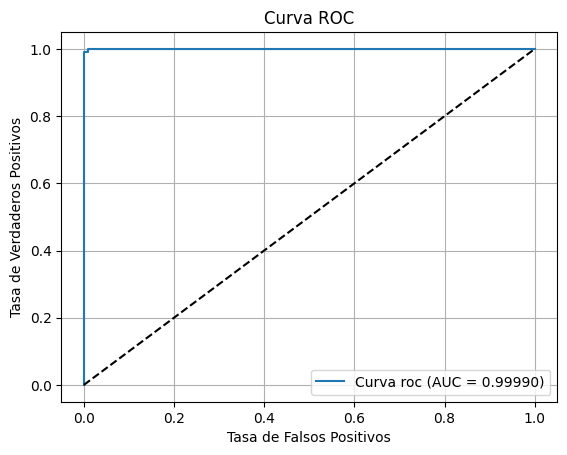


🔹 Reporte de clasificación:
              precision    recall  f1-score   support

           0      1.000     0.860     0.925       100
           1      0.877     1.000     0.935       100

    accuracy                          0.930       200
   macro avg      0.939     0.930     0.930       200
weighted avg      0.939     0.930     0.930       200



In [10]:
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import matplotlib.pyplot as plt
import numpy as np

# Curva ROC y AUC
fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'Curva roc (AUC = {roc_auc:.5f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Reporte de clasificación
print("\n🔹 Reporte de clasificación:")
print(classification_report(y_true, y_pred, digits=3))
